This is my code for the Driven Data "Data Mining the Water Table" Competition

Challenge Link: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/

Data collected from: http://dashboard.taarifa.org/#/dashboard


In [116]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve

train_data_import = pd.read_csv('../Intro to Machine Learning/trainingdata.csv', sep=',') 
train_labels_import = pd.read_csv('../Intro to Machine Learning/trainlabels.csv', sep=',')
test_data_import = pd.read_csv('../Intro to Machine Learning/testdata.csv', sep=',')

# Data Processing
The data in the training set included 41 data points, many of which probably wouldn't help the model. To start off, I looked at each of the columns and intuitively (and with the help of checking how many were null) figured out which data points I wanted to drop. I modified this list a little throughout the process to see how it affected my final accuracy score

In [51]:
# Adding the training labels to the same pandas dataframe as the actual data

train_data_import['label'] = train_labels_import['status_group']
train_data_import.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,label
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


Data columns I want to keep: id, label, amount_tsh, funder, gps_height, installer, longitude, latitude, basin, region, district_code, lga, population, scheme_management, extraction_type, payment_type, water_quality, quantity, source, waterpoint_type

In [52]:
# Making a new dataframe for the columns that I want to keep

keep = ['id', 'label', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'basin', 'region',
       'district_code', 'lga', 'population', 'scheme_management', 'extraction_type', 'payment_type', 'water_quality', 'quantity',
       'source', 'waterpoint_type']

train_data = train_data_import[keep]

train_data.head()

,id,label,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,population,scheme_management,extraction_type,payment_type,water_quality,quantity,source,waterpoint_type
0,69572,functional,6000.0,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,5,Ludewa,109,VWC,gravity,annually,soft,enough,spring,communal standpipe
1,8776,functional,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,2,Serengeti,280,Other,gravity,never pay,soft,insufficient,rainwater harvesting,communal standpipe
2,34310,functional,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Manyara,4,Simanjiro,250,VWC,gravity,per bucket,soft,enough,dam,communal standpipe multiple
3,67743,non functional,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,58,VWC,submersible,never pay,soft,dry,machine dbh,communal standpipe multiple
4,19728,functional,0.0,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,1,Karagwe,0,NaN,gravity,never pay,soft,seasonal,rainwater harvesting,communal standpipe


First, I needed to deal with the null values:

In [58]:
train_data = train_data.dropna()
train_data.head()

,id,label,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,population,scheme_management,extraction_type,payment_type,water_quality,quantity,source,waterpoint_type
0,69572,functional,6000.0,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,5,Ludewa,109,VWC,gravity,annually,soft,enough,spring,communal standpipe
1,8776,functional,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,2,Serengeti,280,Other,gravity,never pay,soft,insufficient,rainwater harvesting,communal standpipe
2,34310,functional,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Manyara,4,Simanjiro,250,VWC,gravity,per bucket,soft,enough,dam,communal standpipe multiple
3,67743,non functional,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,58,VWC,submersible,never pay,soft,dry,machine dbh,communal standpipe multiple
5,9944,functional,20.0,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Pangani,Tanga,8,Mkinga,1,VWC,submersible,per bucket,salty,enough,other,communal standpipe multiple


Since many of the data points above are categorical, I then had to encode them to numerical values.

In [62]:
to_encode = ['funder', 'installer', 'basin', 'region', 'lga', 'scheme_management', 'extraction_type', 'payment_type',
            'water_quality', 'quantity', 'source', 'waterpoint_type']
    
for i in to_encode:
    enc_mjob = preprocessing.LabelEncoder()
    encoded_mjob = enc_mjob.fit_transform(train_data[i])
    train_data[i] = encoded_mjob

train_data

,id,label,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,population,scheme_management,extraction_type,payment_type,water_quality,quantity,source,waterpoint_type
0,69572,functional,6000.0,1249,1390,1412,34.938093,-9.856322e+00,1,3,5,48,109,7,3,0,6,1,8,1
1,8776,functional,0.0,426,1399,508,34.698766,-2.147466e+00,4,9,2,96,280,2,3,2,6,2,5,1
2,34310,functional,25.0,745,686,1910,37.460664,-3.821329e+00,5,8,4,101,250,7,3,5,6,1,0,2
3,67743,non functional,0.0,1593,263,1724,38.486161,-1.115530e+01,7,12,63,81,58,7,14,2,6,0,3,2
5,9944,functional,20.0,891,0,359,39.172796,-4.765587e+00,5,20,8,63,1,7,14,5,4,1,4,2
6,19816,non functional,0.0,310,0,370,33.362410,-3.766365e+00,0,17,3,97,0,7,15,2,6,1,3,4
8,53934,non functional,0.0,1691,0,1873,32.711100,-5.146712e+00,3,19,6,108,0,7,4,2,4,3,3,4
10,49056,functional,0.0,1157,62,1304,39.209518,-7.034139e+00,8,14,43,64,345,4,14,2,4,1,3,6
11,50409,functional,200.0,231,1062,308,35.770258,-1.057417e+01,1,16,5,80,250,9,15,3,6,2,7,4
12,36957,functional,0.0,1714,0,1910,33.798106,-3.290194e+00,0,17,2,54,0,9,8,4,6,1,7,4


Next I split the data into train/test groups so that I could validate later on.

In [63]:
total_num = 51880
train_per = 0.9
train_num = int(total_num*train_per)

In [84]:
train = train_data.sample(n=train_num)
test = train_data.drop(train.index)

In [95]:
train_final = train.drop(['label'], axis=1)
train_final_label = train['label']

test_final = test.drop(['label'], axis=1)
test_final_label = []
for item in test['label']:
    test_final_label.append(item)

# Random Forest Classifier

For my machine learning model, I chose to use a Random forest classifier.

In [103]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(train_final, train_final_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Predicting probabilities for each of the waterpoint categories:

In [106]:
probabilities = clf.predict_proba(test_final) #order of predictions: functional, functional w/repair, non functional
results = pd.DataFrame()
results['functional'] = probabilities[:,0]
results['repair'] = probabilities[:,1] 
results['non functional'] = probabilities[:,2] 
results['actual result'] = test_final_label

,functional,repair,non functional,actual result
0,0.68,0.06,0.26,functional
1,0.92,0.00,0.08,functional
2,0.87,0.01,0.12,functional
3,0.00,0.00,1.00,non functional
4,0.97,0.02,0.01,functional
5,0.21,0.54,0.25,functional needs repair
6,0.11,0.01,0.88,non functional
7,0.64,0.11,0.25,functional
8,0.09,0.00,0.91,non functional
9,1.00,0.00,0.00,functional


# Validation

I'm validating this with a precision recall curve.

In [111]:
results
functional_list = []
nonfunctional_list = []
repair_list = []

for item in results['actual result']:
    if item == "functional":
        functional_list.append(1)
        nonfunctional_list.append(0)
        repair_list.append(0)
    elif item == "non functional":
        functional_list.append(0)
        nonfunctional_list.append(1)
        repair_list.append(0)
    elif item == "functional needs repair":
        functional_list.append(0)
        nonfunctional_list.append(0)
        repair_list.append(1)
        
        

In [121]:
precision_f, recall_f, threshold_f = precision_recall_curve(functional_list,results['functional'])
precision_n, recall_n, threshold_n = precision_recall_curve(nonfunctional_list,results['non functional'])
precision_r, recall_r, threshold_r = precision_recall_curve(repair_list,results['repair'])

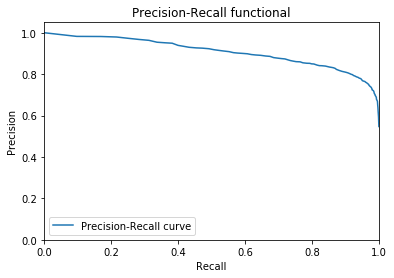

In [127]:
plt.clf()
plt.plot(recall_f, precision_f, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall functional')
plt.legend(loc="lower left")
plt.show()

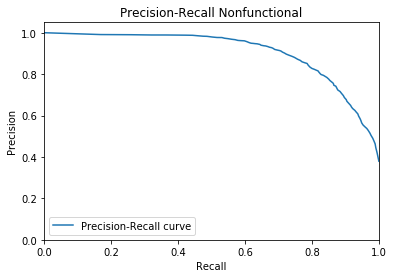

In [126]:
plt.clf()
plt.plot(recall_n, precision_n, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Nonfunctional')
plt.legend(loc="lower left")
plt.show()

This precision recall curve, for the "functional needing repair" category, seemed very low. I'm going to continue to look into ways in which I can increase the area under the curve.

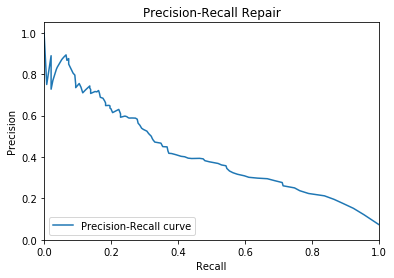

In [146]:
plt.clf()
plt.plot(recall_r, precision_r, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Repair')
plt.legend(loc="lower left")
plt.show()

# Final Predictions

These are the predictions that I plugged into the DrivenData classification metric:

In [128]:
train_last = train_data.drop(['label'], axis=1)
train_last_label = train_data['label']

c=RandomForestClassifier(n_estimators=100)
c.fit(train_last, train_last_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [133]:
test_data_last = test_data_import[['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'basin', 'region',
       'district_code', 'lga', 'population', 'scheme_management', 'extraction_type', 'payment_type', 'water_quality', 'quantity',
       'source', 'waterpoint_type']]

In [138]:
to_encode = ['funder', 'installer', 'basin', 'region', 'lga', 'scheme_management', 'extraction_type', 'payment_type',
            'water_quality', 'quantity', 'source', 'waterpoint_type']

for x in to_encode:
    test_data_last = test_data_last.fillna(" ")
    
for i in to_encode:
    enc_mjob = preprocessing.LabelEncoder()
    encoded_mjob = enc_mjob.fit_transform(test_data_last[i])
    test_data_last[i] = encoded_mjob

In [140]:
predictions = c.predict(test_data_last)
print(predictions)

['non functional' 'functional' 'non functional' ... 'functional'
 'functional' 'non functional']


Exporting my results as a .csv file:

In [145]:
final = pd.DataFrame()
final['id'] = test_data_last['id']
final['status_group'] = predictions
final.to_csv('finalsubmission.csv', index=False)

I put it through the DrivenData classification ranking/error measuring and got 0.7876 accuracy.